# Problem Statement





ERC is a task that aims at predicting emotion of each utterance in a conversation. The following is an excerpt of a conversation with each utterance tagged with corresponding emotion and sentiment label.

![alt text](example.jpg "Title")


# Hierarchical Transformer Network for Utterance-Level Emotion Recognition
This is the Pytorch implementation Utterance-level Emotion Recognition [paper](https://arxiv.org/ftp/arxiv/papers/2002/2002.07551.pdf)

Overview
Though predicting the emotion of a single utterance or sentence, i.e. emotion detection, is a well discussed subject in natural language understanding literature, EmoContext has several novel challenges. In this paper, we address four challenges in utterance-level emotion recognition in dialogue systems:

- Emotion depend on the context of previous utterances in the dialogue

- long-range contextual information is hard to be effectively captured;

- Datasets are quite small.

- the class distribution of training data is significantly different from that of the test data. Consequently, a model trained on the training data might not perform well on the test data.

- We propose a hierarchical transformer framework with a lower-level transformer to model the word-level inputs and an upper-level transformer to capture the contexts of utterance-level embeddings.

# Dataset
Dataset includes the training data set consisting of 720 dialogues, and two evaluation data sets, Dev and Test, containing
80 and 200 dialogues respectively. The Training, validation and test datasets are json files containing following information :

 - Speaker - Identifies the speaker of utterance
 - Utterance -  The textual content of the utterance.
 - Emotion - Emotion labels for each utterance
 - Annotation - The annotation string contains the raw count of votes for each emotion by the annotators. The order of the emotions in the string is [neutral, joy, sadness, fear, anger,  surprise, disgust]. For example, string "2000030" denotes that two annotators voted for "neutral", and three voted for "surprise". Note that the sum of the votes is always five, since the dialogues were annotated by five annotators.

Dataset stattistics:

| Statistics | Train | Dev | Test | 
| :-| :- | :- | :- | 
| # of Dialogues | 713 | 99 |85 | 
| # of Utterances | 9934 | 1344 |1328 | 
| Min number of Utterances per dialogue| 5 | 5 |5 | 
| Max number of Utterances per dialogue| 25 | 25 |25 | 
| Average number of Utterances per dialogue| 13.93 | 13.58 |15.62 | 
| Min Utterance length | 1 | 1 |1 | 
| Max Utterance length | 69 | 37 |45 | 
| Average Utterance length | 7.79 | 7.7 |8.02 | 



    
    

In [18]:
import torch
import os
import random
import pandas as pd
import functools
import time
import math
import argparse
import json
import matplotlib
import matplotlib.patches as patches

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from ipywidgets import interact
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from transformers import DistilBertModel, DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer

from collections import defaultdict

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from sklearn.preprocessing import OneHotEncoder

In [2]:
def get_args():
    """
        returns the Parser args
    """
    root_dir = os.getcwd()  
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--projection_size', type=int, default=200)
    parser.add_argument('--n_layers', type=int, default=2)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--lr', type=float, default=2e-5)
    parser.add_argument('--bert_lr', type=float, default=1e-5)
    parser.add_argument('--layerwise_decay', default=0.95, type=float,  
                    help='layerwise decay factor for the learning rate of the pretrained DistilBert')
    
    #parser.add_argument('--train_file', default=os.path.join(root_dir, 'data/clean_train.txt'), type=str)
    #parser.add_argument('--val_file', default=os.path.join(root_dir, 'data/clean_val.txt'), type=str)
    #parser.add_argument('--test_file', default=os.path.join(root_dir, 'data/clean_test.txt'), type=str)
    parser.add_argument('--weight_decay', type=float, default=1e-5)
    parser.add_argument('--max_grad_norm', type=float, default=1.0)
    parser.add_argument('--epochs', type=int, default=2,
                        help='number of total epochs to run')
    parser.add_argument('--max_seq_len', type=int, default=35   )
   
    parser.add_argument('--alpha', type=float, default=0.95)
    parser.add_argument('--seed', type=int, default=123,
                       help='seed for initializing training')
    parser.add_argument('--device', type=int, default=0)

    parser.add_argument('--evaluate', action='store_true')
    parser.add_argument('--gpu', type=str, default='0',		# Spcify the GPU for training
	                    help='gpu: default 0')
    parser.add_argument('--emoset', type=str, default = 'emorynlp',
                        help = 'Emotion Training Set Name')
    parser.add_argument('--speaker_embedding',  action="store_true",
                        help = 'Enable Speaker Embedding')
    args = parser.parse_args(args=['--speaker_embedding', '--emoset', 'emorynlp'])
    return args

In [3]:
args = get_args()
print(args, '\n')
args.emoset = args.emoset.lower()
assert args.emoset  in ['emorynlp', 'emotionpush', 'friends','semeval']
if args.emoset == 'semeval':
    args.speaker_embedding = False 

if not args.emoset == 'semeval':
    args.batch_size = 1


Namespace(alpha=0.95, batch_size=1, bert_lr=1e-05, device=0, dropout=0.1, emoset='emorynlp', epochs=2, evaluate=False, gpu='0', layerwise_decay=0.95, lr=2e-05, max_grad_norm=1.0, max_seq_len=35, n_layers=2, projection_size=200, seed=123, speaker_embedding=True, weight_decay=1e-05) 



### Set the seed for deterministic behavior

In [4]:
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
seed_everything(42, workers=True)

Global seed set to 42


42

### Set cuda device

In [5]:
device = torch.device("cuda:{}".format(int(args.gpu)) if torch.cuda.is_available() else "cpu")
args.device = device
print('Args.device = {}'.format(args.device))

Args.device = cuda:0


In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Read Dataset CSV Files

In [7]:
'''
  Create Pandas Dataframe from EmoryNLP Dataset Json Files
  Parameters
    ----------
    Data : Json File 
        Json File containing Train/Val/Test Data
    Column_list : Python List
        Column list for the created dataframe    
    Returns
    -------
   df: Pandas Dataframe
'''

def create_df_emorynlp(data, column_list):
    df = pd.DataFrame(columns = column_list)
    dialogue_idx = 0
    episode_idx = 0
    for episode in data['episodes']:
        scenes = episode['scenes']
        for i in range(len(scenes)):
            for j in range(len(scenes[i]['utterances'])):
                df2 = pd.DataFrame([[dialogue_idx, scenes[i]['utterances'][j]['transcript'] , scenes[i]['utterances'][j]['speakers'][0], len(scenes[i]['utterances'][j]['transcript'].split()), scenes[i]['utterances'][j]['emotion'].lower() ]], columns = column_list)
                df = df.append(df2, ignore_index=True)
            dialogue_idx += 1
        episode_idx = episode_idx+1
    return df

'''
  Create Pandas Dataframe from Friends/EmotionPush Dataset Json Files
   Parameters
    ----------
    Data : Json File 
        Json File containing Train/Val/Test Data
    Column_list : Python List
        Column list for the created dataframe    
    Returns
    -------
   df: Pandas Dataframe
'''
def create_df_friends(data, column_list):
    df = pd.DataFrame(columns = column_list)
    dialogue_idx = 0
    for dialog in data:
        for utter in dialog:
            df2 = pd.DataFrame([[dialogue_idx, utter['utterance'], utter['speaker'], len(utter['utterance'].split()), utter['emotion'].lower() ]], columns = column_list)
            df = df.append(df2, ignore_index=True)
        dialogue_idx += 1
    return df

def create_df(data, emoset):
    column_list = list(('dialogue_id', 'utterance', 'speaker','utterance_len', 'label'))
    if emoset == 'emorynlp':
        df=  create_df_emorynlp(data, column_list)
    elif emoset == 'friends' or emoset == 'emotionpush':
        df = create_df_friends(data, column_list)
     
    return df

'''
  Create Pandas Dataframe for Train, Validation and Test Data from Dataset Json Files
  
'''
def load_df(args):
    
    if args.emoset == 'emorynlp':
        print('Creating Training/Val/Test Dataframesfor EmoryNLP Dataset')
        train_path = '../data/EmoryNLP/json/emotion-detection-trn.json'
        val_path = '../data/EmoryNLP/json/emotion-detection-dev.json'
        test_path = '../data/EmoryNLP/json/emotion-detection-tst.json'
    elif  args.emoset == 'emotionpush':
        print('Creating Training/Val/Test Dataframesfor EmotionPush Dataset')
        train_path = '../data/Emotionpush/emotionpush.train.json'
        val_path =   '../data/Emotionpush/emotionpush.dev.json'
        test_path =  '../data/Emotionpush/emotionpush.test.json'
    elif  args.emoset == 'friends': 
        print('Creating Training/Val/Test Dataframesfor Friends Dataset')
        train_path = '../data/Friends/friends.train.json'
        val_path = '../data/Friends/friends.dev.json'
        test_path = '../data/Friends/friends.test.json'
    else:
        print('Creating Training/Val/Test Dataframesfor Semeval Dataset')
        train_path = '../data/clean_train.txt'
        val_path = '../data/clean_val.txt'
        test_path = '../data/clean_test.txt'

    if not args.emoset == 'semeval':
        with open(train_path, encoding='utf-8') as data_file:
            train_json = json.loads(data_file.read())
        
        with open(val_path, encoding='utf-8') as data_file:
            val_json = json.loads(data_file.read())
        
        with open(test_path, encoding='utf-8') as data_file:
            test_json = json.loads(data_file.read())
        
        df_train = create_df(train_json, args.emoset)
        df_val = create_df(val_json,  args.emoset)       
        df_test = create_df(test_json,  args.emoset) 
    else:
        df_train = pd.read_csv(train_path, delimiter='\t', index_col='id')
        df_val =  pd.read_csv(val_path, delimiter='\t', index_col='id')    
        df_test = pd.read_csv(test_path, delimiter='\t', index_col='id')
                
    return (df_train, df_val, df_test)
    

In [8]:
(df_train, df_val, df_test)  = load_df(args)   

Creating Training/Val/Test Dataframesfor EmoryNLP Dataset


In [11]:
df_train

,dialogue_id,utterance,speaker,utterance_len,label
0,0,"What you guys don't understand is, for us, kis...",Monica Geller,17,joyful
1,0,"Yeah, right!.......Y'serious?",Joey Tribbiani,2,neutral
2,0,"Oh, yeah!",Phoebe Buffay,2,joyful
3,0,Everything you need to know is in that first k...,Rachel Green,10,powerful
4,0,Absolutely.,Monica Geller,1,powerful
...,...,...,...,...,...
9929,712,"Ahh, yes, I will have a glass of the Merlot",Rachel Green,10,neutral
9930,712,Okay.,Air Hostess,1,neutral
9931,712,"And uh, he will have a white wine spritzer.",Rachel Green,9,neutral
9932,712,"Okay, good. Thank you. I'll be back shortly, a...",Air Hostess,10,joyful


### We define 2 set of dictionaries
- emodict : Enumerate the emotions present in the dataset
- focus_dict : Enumerate the smaller subset of emotions that we want to focus on

For EmotionPush Dataset, we train the model to learn 4 emotions('neutral', 'sadness', 'anger', 'joy') out of 8 present in the dataset

In [12]:
if args.emoset == 'emorynlp':
    emo_dict= {'neutral': 0, 'sad': 1, 'mad':2, 'joyful':3, 'peaceful':4,'powerful':5, 'scared':6}
    focus_dict = ['neutral', 'sad', 'mad', 'joyful', 'peaceful', 'powerful', 'scared']
elif args.emoset == 'friends':
    emo_dict = {'neutral': 0, 'sadness': 1, 'anger':2, 'joy':3, 'non-neutral':4,'surprise':5, 'fear':6, 'disgust':7}
    focus_dict = ['neutral', 'sadness', 'anger', 'joy']
elif args.emoset == 'emotionpush':
    emo_dict = {'neutral': 0, 'sadness': 1, 'anger':2, 'joy':3, 'non-neutral':4,'surprise':5, 'fear':6, 'disgust':7}
    focus_dict = ['neutral', 'sadness', 'anger', 'joy']
elif args.emoset == 'semeval':
    emo_dict = {'others': 0, 'sad': 1, 'angry':2, 'happy':3}
    focus_dict = ['sad', 'angry', 'happy']

print('Emotion Mapping {}'.format(emo_dict))
print('Focus Emotion {}'.format(focus_dict))
emo_count = {}
for emo in emo_dict.keys():
        emo_count[emo] =df_train['label'].value_counts()[emo]
print('Emotion Label Distribution in Training Set {}'.format(emo_count))

emo_count = {}
for emo in emo_dict.keys():
        emo_count[emo] =df_val['label'].value_counts()[emo]
print('Emotion Label Distribution in Validation Set {}'.format(emo_count))
emo_count = {}
for emo in emo_dict.keys():
    emo_count[emo] =df_test['label'].value_counts()[emo]
print('Emotion Label Distribution in Test Set {}'.format(emo_count))

Emotion Mapping {'neutral': 0, 'sad': 1, 'mad': 2, 'joyful': 3, 'peaceful': 4, 'powerful': 5, 'scared': 6}
Focus Emotion ['neutral', 'sad', 'mad', 'joyful', 'peaceful', 'powerful', 'scared']
Emotion Label Distribution in Training Set {'neutral': 3034, 'sad': 671, 'mad': 1076, 'joyful': 2184, 'peaceful': 900, 'powerful': 784, 'scared': 1285}
Emotion Label Distribution in Validation Set {'neutral': 393, 'sad': 75, 'mad': 143, 'joyful': 289, 'peaceful': 132, 'powerful': 134, 'scared': 178}
Emotion Label Distribution in Test Set {'neutral': 349, 'sad': 98, 'mad': 113, 'joyful': 282, 'peaceful': 159, 'powerful': 145, 'scared': 182}


#  Number of Dialogues in Training and Evaluation Sets

In [35]:
len(df_train['dialogue_id'].unique()), len(df_val['dialogue_id'].unique()), len(df_test['dialogue_id'].unique())

(713, 99, 85)

#  Number of utterances in Training and Evaluation Sets

In [36]:
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(9934, 1344, 1328)

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9934 entries, 0 to 9933
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dialogue_id    9934 non-null   object
 1   utterance      9934 non-null   object
 2   speaker        9934 non-null   object
 3   utterance_len  9934 non-null   object
 4   label          9934 non-null   object
dtypes: object(5)
memory usage: 388.2+ KB


In [38]:
df_train['label'].value_counts(), df_val['label'].value_counts(), df_test['label'].value_counts()

(neutral     3034
 joyful      2184
 scared      1285
 mad         1076
 peaceful     900
 powerful     784
 sad          671
 Name: label, dtype: int64,
 neutral     393
 joyful      289
 scared      178
 mad         143
 powerful    134
 peaceful    132
 sad          75
 Name: label, dtype: int64,
 neutral     349
 joyful      282
 scared      182
 peaceful    159
 powerful    145
 mad         113
 sad          98
 Name: label, dtype: int64)

#  Comparison of class distribution in Training vs Evaluation data sets

| Emotion | Neutral | Sad | Anger(Mad) | Joy | Peaceful | Powerful | Scared| # |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Train | 3034 |671 | 1076| 2184|900 |784 | 1285| 9934|
| Dev | 393 |75 | 143| 289|132 |134 | 178| 1344|
| Test | 349 |98 | 113| 282|159 |145 | 182| 1328|

In [39]:
data = [df_train['label'], df_val['label'], df_test['label']]
columns=list(('Training', 'Validation', 'Test'))
df_labels = pd.concat(data, axis=1, keys=columns)

In [40]:
set(df_train.label)

{'joyful', 'mad', 'neutral', 'peaceful', 'powerful', 'sad', 'scared'}

[Text(0, 0, 'neutral'),
 Text(1, 0, 'sad'),
 Text(2, 0, 'mad'),
 Text(3, 0, 'joyful'),
 Text(4, 0, 'peaceful'),
 Text(5, 0, 'powerful'),
 Text(6, 0, 'scared')]

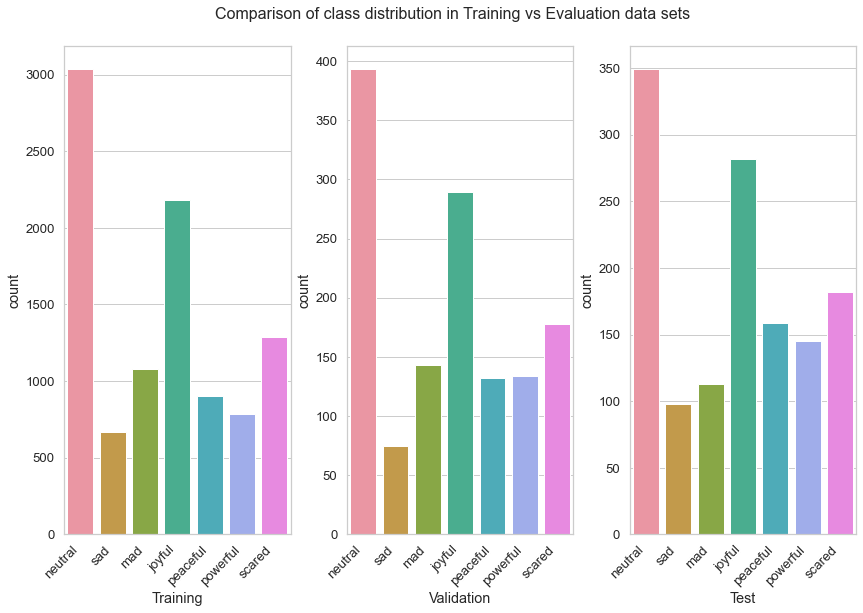

In [41]:
fig, ax =plt.subplots(1,3)
fig.suptitle('Comparison of class distribution in Training vs Evaluation data sets', fontsize=16)
fig.tight_layout()
emotion_list = ['neutral', 'sad', 'mad', 'joyful','peaceful', 'powerful', 'scared' ]
chart = sns.countplot(x="Training",   data=df_labels, order = emotion_list, ax=ax[0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Validation", data=df_labels, order = emotion_list, ax=ax[1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Test",       data=df_labels, order = emotion_list, ax=ax[2])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [42]:
df_train['label'].value_counts(), df_val['label'].value_counts(), df_test['label'].value_counts()


(neutral     3034
 joyful      2184
 scared      1285
 mad         1076
 peaceful     900
 powerful     784
 sad          671
 Name: label, dtype: int64,
 neutral     393
 joyful      289
 scared      178
 mad         143
 powerful    134
 peaceful    132
 sad          75
 Name: label, dtype: int64,
 neutral     349
 joyful      282
 scared      182
 peaceful    159
 powerful    145
 mad         113
 sad          98
 Name: label, dtype: int64)

# Scale of class imbalance is similar in Training and Evaluation data sets

| Emotion | Neutral | Sad | Anger(Mad) | Joy | Peaceful | Powerful | Scared|
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | 
| Train | 30% |7% | 11%| 22%|9%|8% | 13%|
| Dev | 29% |6% | 11%| 21%|10% |10% | 13%| 
| Test | 26% |7% |9%| 21%|12% |11% | 14%|

Distribution of classes is almost similar among training and eval sets

In [43]:
train = pd.Series(['Training'] , ['name'])
train = train.append(df_labels['Training'].value_counts().div(df_labels['Training'].value_counts().sum()))
val = pd.Series(['Validation'] , ['name'])
val = val.append(df_labels['Validation'].value_counts().div(df_labels['Validation'].value_counts().sum()))
test = pd.Series(['Test'] , ['name'])
test = test.append(df_labels['Test'].value_counts().div(df_labels['Test'].value_counts().sum()))

df_stacked = pd.DataFrame(columns = emotion_list)

df_stacked = df_stacked.append(train,ignore_index=True)
df_stacked = df_stacked.append(val,ignore_index=True)
df_stacked = df_stacked.append(test,ignore_index=True)

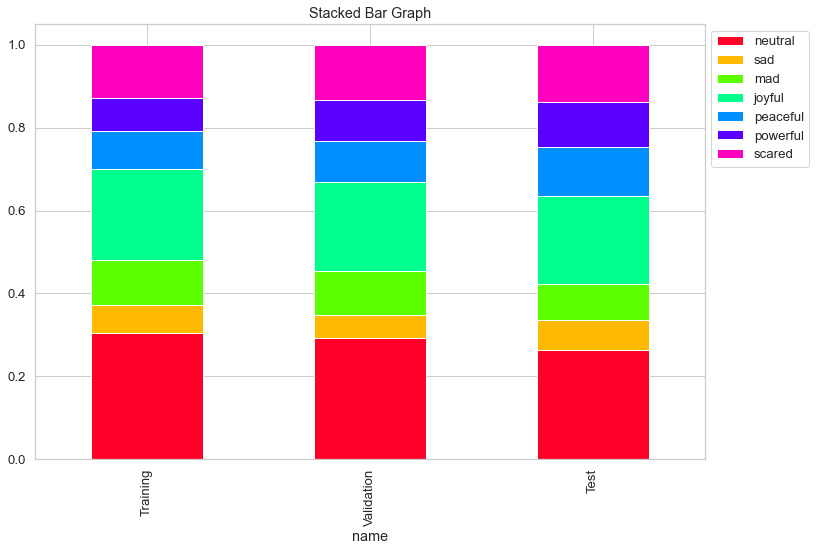

In [44]:
# plot a Stacked Bar Chart using matplotlib
df_stacked.plot(
    x = 'name',
    kind = 'bar',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = False, 
    colormap='gist_rainbow'
   ).legend(bbox_to_anchor=(1, 1))

# Distribution of number of utterances per dialogue in Train and Evaluation Sets
- Minimum and maximum value of number of utterances per dialogue is same across 3 sets, 5 and 25 respectively


In [45]:
train_dialogue_id_list = list((df_train['dialogue_id'].unique()))
val_dialogue_id_list = list((df_val['dialogue_id'].unique()))
test_dialogue_id_list = list((df_test['dialogue_id'].unique()))
d = {"Training":[],"Validation":[],"Test":[] };
for dialogue in train_dialogue_id_list:
     d['Training'].append((df_train.dialogue_id ==dialogue).sum())
for dialogue in val_dialogue_id_list:
     d['Validation'].append((df_val.dialogue_id ==dialogue).sum())
for dialogue in test_dialogue_id_list:
     d['Test'].append((df_test.dialogue_id ==dialogue).sum())




In [46]:

print('Train Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Training']), max(d['Training']), np.round(sum(d['Training'])/len(d['Training']), 2)))
print('Validation Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Validation']), max(d['Validation']), np.round(sum(d['Validation'])/len(d['Validation']), 2)))
print('Test Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Test']), max(d['Test']), np.round(sum(d['Test'])/len(d['Test']), 2)))

Train Set: Utterance per dialogue statistics : Min: 5, Max: 25 Avg: 13.93
Validation Set: Utterance per dialogue statistics : Min: 5, Max: 25 Avg: 13.58
Test Set: Utterance per dialogue statistics : Min: 5, Max: 25 Avg: 15.62


<AxesSubplot:title={'center':'Test'}, ylabel='Count'>

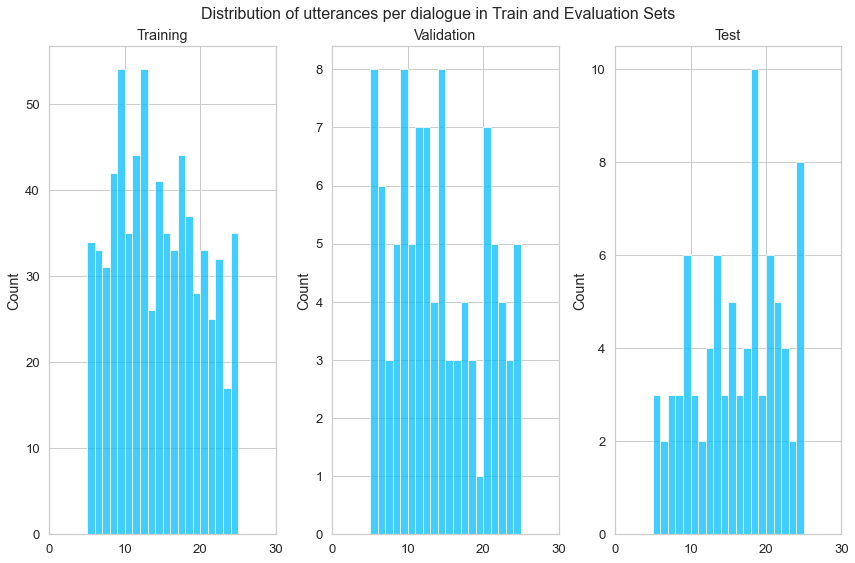

In [48]:
fig, ax =plt.subplots(ncols=3)
fig.suptitle('Distribution of utterances per dialogue in Train and Evaluation Sets', fontsize=16)
fig.tight_layout()
ax[0].set_title('Training')
ax[0].set_xlim([0, 30])
sns.histplot(d['Training'] , ax=ax[0], bins=20, stat = 'count' )

ax[1].set_title('Validation')
ax[1].set_xlim([0, 30])
sns.histplot(d['Validation'] , ax=ax[1], bins=20, stat = 'count')

ax[2].set_title('Test')
ax[2].set_xlim([0, 30])
sns.histplot(d['Test'] , ax=ax[2], bins=20, stat = 'count')


# Distribution of Utterance Length in Train and Evaluation Sets
- Length of utterances follows almost similar distribution in train and evaluation datasets
- Max seq len can be taken around 35


In [49]:
d = {"Training":[],"Validation":[],"Test":[] }

d['Training'] = list(df_train['utterance_len'].values)
d['Validation'] = list(df_val['utterance_len'].values)
d['Test'] = list(df_test['utterance_len'].values)

Minimum and maximum value of utterance length in train, val and test sets

In [50]:
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Training']), max(d['Training']), np.round(sum(d['Training'])/len(d['Training']), 2)))
print('Validation Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Validation']), max(d['Validation']), np.round(sum(d['Validation'])/len(d['Validation']), 2)))
print('Test Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Test']), max(d['Test']), np.round(sum(d['Test'])/len(d['Test']), 2)))

Train Set: Utterance length statistics : Min: 1, Max: 148 Avg: 10.45
Validation Set: Utterance length statistics : Min: 1, Max: 69 Avg: 10.03
Test Set: Utterance length statistics : Min: 1, Max: 77 Avg: 10.18


In [58]:
print('99 percentile for Training Data {}'.format(np.percentile(np.asarray(d['Training']), 99)))
print('99 percentile for Validation Data {}'.format(np.percentile(np.asarray(d['Validation']), 99)))
print('99 percentile for Test Data {}'.format(np.percentile(np.asarray(d['Test']), 99)))

99 percentile for Training Data 52.0
99 percentile for Validation Data 45.569999999999936
99 percentile for Test Data 51.73000000000002


In [59]:
for i in range(max(d['Training'])+1):
    print('value = {}, value_Count = {}'.format(i,d['Training'].count(i) ))

value = 0, value_Count = 0
value = 1, value_Count = 1166
value = 2, value_Count = 714
value = 3, value_Count = 694
value = 4, value_Count = 716
value = 5, value_Count = 704
value = 6, value_Count = 623
value = 7, value_Count = 606
value = 8, value_Count = 460
value = 9, value_Count = 408
value = 10, value_Count = 408
value = 11, value_Count = 340
value = 12, value_Count = 309
value = 13, value_Count = 251
value = 14, value_Count = 246
value = 15, value_Count = 209
value = 16, value_Count = 182
value = 17, value_Count = 180
value = 18, value_Count = 160
value = 19, value_Count = 149
value = 20, value_Count = 117
value = 21, value_Count = 134
value = 22, value_Count = 101
value = 23, value_Count = 79
value = 24, value_Count = 88
value = 25, value_Count = 73
value = 26, value_Count = 72
value = 27, value_Count = 64
value = 28, value_Count = 48
value = 29, value_Count = 54
value = 30, value_Count = 40
value = 31, value_Count = 49
value = 32, value_Count = 29
value = 33, value_Count = 29
va

[Text(0.5, 46.5, 'Utterance_length'),
 Text(548.6588235294118, 0.5, 'Probability')]

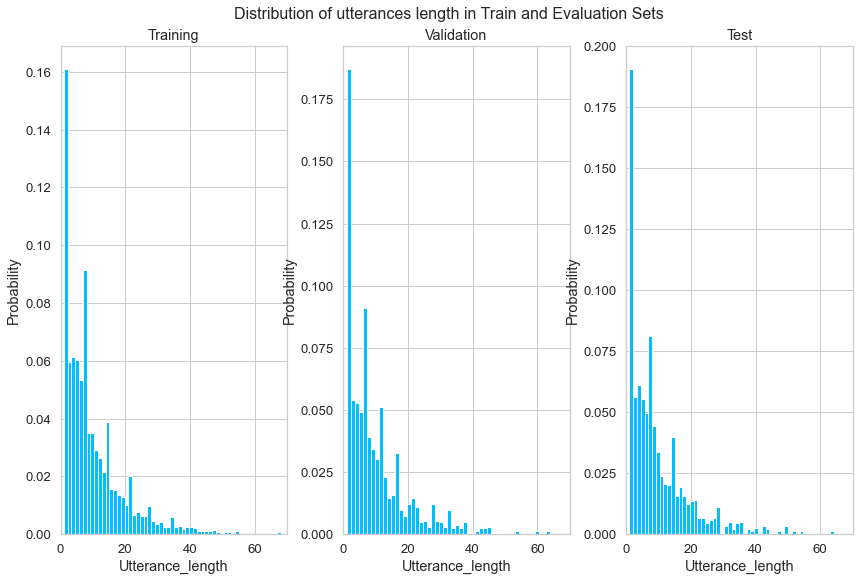

In [71]:
fig, ax =plt.subplots(1,3)
fig.suptitle('Distribution of utterances length in Train and Evaluation Sets', fontsize=16)
fig.tight_layout()

ax[0].set_title('Training')
ax[0].set_xlim([0, 70])
ax[0].set(xlabel='Utterance_length', ylabel='Probability')
ax[0].hist(d['Training'], bins = 125, density = True)

ax[1].set_title('Validation')
ax[1].set_xlim([0, 70])
ax[1].hist(d['Validation'], bins = 55, density = True)
ax[1].set(xlabel='Utterance_length', ylabel='Probability')


ax[2].set_title('Test')
ax[2].set_xlim([0, 70])
ax[2].hist(d['Test'], bins = 65, density = True)
ax[2].set(xlabel='Utterance_length', ylabel='Probability')

# Label Transition Probability Visualization
- To check for possible patterns in the label sequences of the datasets, we plot frequency of the label
  pairs (x;y) where x and y are the labels of ${U}_{s_{t-1}, t-1}$ and ${U}_{s_{t}, t}$ respectively
- Plot show the same emotion label or neutral label appearing in the consecutive utterances with high frequency. This may    
  induce label dependencies and consistencies and can be called as the label copying feature of the dataset.

In [22]:
def VisualizeTransitionProb(df, emo_dict):
    df_trans_prob = pd.DataFrame([emo_dict[label] for label in df_train['label'].values])
    df_trans_prob['shift'] = df_trans_prob[0].shift(-1)
    df_trans_prob['count'] = 1
    trans_mat = df_trans_prob.groupby([0, 'shift']).count().unstack().fillna(0)
    myMatrix = np.round(trans_mat.div(trans_mat.sum(axis=1), axis=0).values,2)
    print(myMatrix)
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')

    plt.style.use(['ggplot'])
    plt.ylabel('From State')
    plt.xlabel('To State')
    mymap = plt.get_cmap("YlGnBu")
    #mymap = plt.get_cmap("Reds")
    # mymap = plt.get_cmap("Greys")
    normalize = matplotlib.colors.LogNorm(vmin=0.0001, vmax=1)
    normalize = matplotlib.colors.PowerNorm(gamma=0.5, vmin=0.01, vmax=1)
    matrix_size = myMatrix.shape[0]
    square_size = 1.0 / matrix_size

    diagonal = myMatrix.diagonal()
    # colors = []

    #ax.set_xticklabels(range(0, matrix_size))
    #ax.set_yticklabels(range(0, matrix_size))

    ax.set_xticklabels(emo_dict.keys(), rotation=90, horizontalalignment='right')
    ax.set_yticklabels(list(reversed(emo_dict.keys())), rotation=0, horizontalalignment='right')


    ax.xaxis.set_ticks(np.arange(0 + 0.5 * square_size, 1 + 0.5 * square_size, square_size))
    ax.yaxis.set_ticks(np.arange(0 + 0.5 * square_size, 1 + 0.5 * square_size, square_size))



    # iterate over all elements of the matrix
    8
    for i in range(matrix_size):
        for j in range(matrix_size):
            if myMatrix[i, j] > 0:
                rect_size = np.sqrt(myMatrix[i, j]) * square_size
            else:
                rect_size = 0

            dx = 0.5 * (square_size - rect_size)
            dy = 0.5 * (square_size - rect_size)
            #print(' {} {}'.format((i) * square_size + dx, j * square_size + dy))
            p = patches.Rectangle(
                (j * square_size + dy, (matrix_size-i-1) * square_size + dx),
                rect_size,
                rect_size,
                fill=True,
                color=mymap(normalize(myMatrix[i, j]))
            )
            ax.add_patch(p)

    cbax = fig.add_axes([0.85, 0.12, 0.05, 0.78])
    cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=mymap, orientation='vertical')
    cb.set_label("Transition Probability")
    plt.show(block=True)
    plt.interactive(False)

[[0.46 0.06 0.09 0.18 0.06 0.05 0.11]
 [0.29 0.2  0.07 0.12 0.11 0.08 0.13]
 [0.25 0.05 0.24 0.16 0.09 0.07 0.15]
 [0.25 0.05 0.08 0.37 0.08 0.06 0.11]
 [0.2  0.09 0.1  0.22 0.18 0.1  0.12]
 [0.19 0.06 0.11 0.2  0.13 0.17 0.14]
 [0.24 0.06 0.13 0.16 0.1  0.11 0.2 ]]


<ipython-input-22-e0fcc787386a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(emo_dict.keys(), rotation=90, horizontalalignment='right')
<ipython-input-22-e0fcc787386a>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(emo_dict.keys())), rotation=0, horizontalalignment='right')


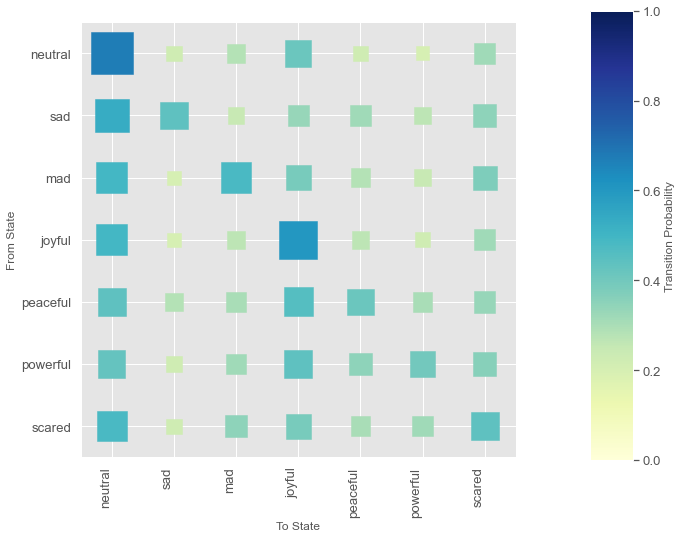

In [23]:
VisualizeTransitionProb(df_train, emo_dict)

# Data Preprocessing

Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are using BERT for modelling the word level inputs, we need to do following preprocessing

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

We will use the pretrained bert model and tokenizers from the Transformers Library 

# DataLoader Class
As the same utterance can deliver different emotions when it is in different contexts, it is imperative to look at the context of previous utterances in the dialogue while modellign the emotion label. On the other hand, utterances between 2 dialogues are independent of each other. As each dialogue will have different utterlance length. we canot use a constant batch size. 
For this task, We create a class called CustomDataset, and pass the argument Dataset, to allow it to inherit the functionality of the Torch Dataset Class.

In [74]:
class CustomDataset(Dataset):
    def __init__(self, df, max_number_of_speakers_in_dialogue, emo_dict, args):
        self.data = df
     
        self.max_number_of_speakers_in_dialogue = max_number_of_speakers_in_dialogue
        self.emo_dict = emo_dict
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.args = args
        
    def __len__(self):
        if not self.args.emoset == 'semeval':
            return len( self.data['dialogue_id'].unique())
        else:
            return self.data.shape[0]
    
    def get_labels(self, df):
        """
        returns the labels according to the emotion dictionary
        """
        return torch.tensor([self.emo_dict[label] for label in df['label'].values])
    
    '''
        Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are
        using BERT for modelling the word level inputs, we need to do following preprocessing

        - Add special tokens to separate sentences and do classification
        - Pass sequences of constant length (introduce padding)
        - Create array of 0s (pad token) and 1s (real token) called attention mask

        We will use the pretrained bert model and tokenizers from the Transformers Library 
    
    '''
    
    def transform_data(self, df, max_seq_len):
        """
        returns the padded input ids and attention masks according to the DistilBert tokenizer
        """
               
        def tokenize_fct(turn):
            return self.tokenizer.encode(turn, truncation = True, add_special_tokens=True, max_length=max_seq_len)
        
        if not self.args.emoset == 'semeval':
            tokenized = df[['utterance']].applymap(tokenize_fct)
            padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
            attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
        else:
            tokenized = df[['turn1','turn2','turn3']].applymap(tokenize_fct)
            padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
            attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
        return padded, attention_mask, tokenized

    
    def __getitem__(self, idx):
        
        if not self.args.emoset == 'semeval':
            assert idx  in list(range (len( self.data['dialogue_id'].unique())))
            df = self.data.loc[self.data.dialogue_id ==idx]
        else:
            df = self.data.loc[self.data.index ==idx]
        padded, attention_mask, tokenizer = self.transform_data(df, self.args.max_seq_len)
        labels = self.get_labels(df)
        
        if not self.args.emoset == 'semeval':
            padded = padded.squeeze(dim=1)
            attention_mask = attention_mask.squeeze(dim=1)
        else:
            padded = padded.squeeze(dim=0)
            attention_mask = attention_mask.squeeze(dim=0)
        padded = padded.cuda(self.args.device)
        attention_mask = attention_mask.cuda(self.args.device)
        labels = labels.cuda(self.args.device)
        if self.args.speaker_embedding:
            cat = OneHotEncoder()
            speakers_array = np.array(df.speaker).reshape(-1, 1)
            number_of_speakers_in_dialogue = np.unique(speakers_array).shape[0]
            spkr_emd = cat.fit_transform(speakers_array).toarray()
            spkr_emd = np.pad(spkr_emd, (0, (self.max_number_of_speakers_in_dialogue - number_of_speakers_in_dialogue)))[0:spkr_emd.shape[0], :]
        else:
            spkr_emd = 0
        
        return padded, attention_mask, spkr_emd, labels

## Transformer Sentence Embeddings

We use a pretrained DistilBert model to create sentence embeddings for each utterance. We obtain contextual word embeddings by concatenating the CLS token embedding and the mean of the last layer. 

For more information on the (Distil)Bert models one can look at 
Jay Alammar's blog posts ([A Visual Guide to Using BERT for the First Time](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) and [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)) where also the following illustration is taken from.

![DistilBert output](./images/bert-distilbert-output-tensor-predictions.png)

Further references:
 
* [DistilBert paper](https://arxiv.org/abs/1910.01108) and [blog post](https://medium.com/huggingface/distilbert-8cf3380435b5)
* [Original Bert (Bidirectional Encoder Representations from Transformers) paper](https://arxiv.org/abs/1810.04805)
* [tutorial for custom PyTorch modules](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
* [Huggingface transformers documentation](https://huggingface.co/transformers/v2.3.0/index.html)

In [75]:

class sentence_embeds_model(torch.nn.Module):
    """
    instantiates the pretrained DistilBert model and the linear layer
    """
    
    def __init__(self, args, dropout = 0.1):
        super(sentence_embeds_model, self).__init__()
        
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=dropout, 
                                                           output_hidden_states=True)
        
        self.embedding_size = 2 * self.transformer.config.hidden_size
        self.args = args
      
        
    def layerwise_lr(self, lr, decay):
        """
        returns grouped model parameters with layer-wise decaying learning rate
        """
        bert = self.transformer
        num_layers = bert.config.n_layers
        opt_parameters = [{'params': bert.embeddings.parameters(), 'lr': lr*decay**num_layers}]
        opt_parameters += [{'params': bert.transformer.layer[l].parameters(), 'lr': lr*decay**(num_layers-l+1)} 
                            for l in range(num_layers)]
        return opt_parameters
               
    def forward(self, input_ids = None, attention_mask = None, input_embeds = None):
        """
        returns the sentence embeddings
        """
        utterance_count = input_ids.shape[1]
        
        if input_ids is not None:
            input_ids = input_ids.flatten(end_dim = 1)
     
        if attention_mask is not None:
            attention_mask = attention_mask.flatten(end_dim = 1)
        
       
       
        output = self.transformer(input_ids = input_ids, 
                                  attention_mask = attention_mask, inputs_embeds = input_embeds)
      
        cls = output[0][:,0]
        hidden_mean = torch.mean(output[1][-1],1)
        sentence_embeds = torch.cat([cls, hidden_mean], dim = -1)
        sentence_embeds = sentence_embeds.view(-1,utterance_count, self.embedding_size)
       
        return sentence_embeds

## Context Transformer and Classification

We use another transformer model to create contextual sentence embeddings, i.e. we model that a conversation consists of multiple utterances. Moreover, we add a classification model for the emotion of the last utterance where we augment the loss by a binary loss due to the unbalanced data.

Note that for our convenience we use

* a linear projection of the sentence embeddings to a given `projection_size`
* a (not pre-trained) DistilBertForSequenceClassification and flip the order of the utterances as the first input embedding gets classified by default
* only one attention head, see also the paper [Are Sixteen Heads Really Better than One?](https://arxiv.org/abs/1905.10650).

In [76]:
class context_classifier_model(torch.nn.Module):
    """
    instantiates the DisitlBertForSequenceClassification model, the position embeddings of the utterances, 
    and the binary loss function
    """
    
    def __init__(self, 
                 embedding_size, 
                 projection_size, 
                 n_layers, 
                 emo_dict, 
                 focus_dict, 
                 max_number_of_speakers_in_dialogue, 
                 max_number_of_utter_in_dialogue,
                 args,
                 loss_weights,
                 dropout = 0.1):
        super(context_classifier_model, self).__init__()
     
        self.projection_size = projection_size
        self.projection = torch.nn.Linear(embedding_size, projection_size)  
        self.max_number_of_speakers_in_dialogue = max_number_of_speakers_in_dialogue
        self.max_number_of_utter_in_dialogue = max_number_of_utter_in_dialogue
        self.position_embeds = torch.nn.Embedding( self.max_number_of_utter_in_dialogue, projection_size)
     
        self.norm = torch.nn.LayerNorm(projection_size+self.max_number_of_speakers_in_dialogue)
        self.drop = torch.nn.Dropout(dropout)
        self.focus_dict = focus_dict
        self.emo_dict = emo_dict
        self.args = args
        self.loss_weights = loss_weights
        context_config = DistilBertConfig(dropout=dropout, 
                                dim=projection_size+self.max_number_of_speakers_in_dialogue,
                                hidden_dim=4*projection_size,
                                n_layers=n_layers,
                                n_heads = 1,
                                num_labels=len(self.emo_dict.keys()))

        self.context_transformer = DistilBertForSequenceClassification(context_config)
        if not self.args.emoset == 'semeval':
            self.others_label = self.emo_dict['neutral']
        else:
            self.others_label = self.emo_dict['others']
        self.bin_loss_fct = torch.nn.BCEWithLogitsLoss()
   
        
    def bin_loss(self, logits, labels):
        """
        defined the additional binary loss for the `others` label
        """
        bin_labels = torch.where(labels == self.others_label, torch.ones_like(labels), 
                                 torch.zeros_like(labels)).float()
        bin_logits = logits[:, self.others_label]    
        return self.bin_loss_fct(bin_logits, bin_labels)

    
    
    def comput_loss(self, log_prob, target, weights):
        """ Weighted loss function """
        #loss = F.nll_loss(log_prob, target, weight=weights, reduction='sum')
        loss = F.cross_entropy(log_prob, target, weight=weights, reduction='sum')
        loss /= target.size(0)

        return loss


    def forward(self, sentence_embeds, spkr_emd, labels = None):
        """
        returns the logits and the corresponding loss if `labels` are given
        """
        
        position_ids = torch.arange(sentence_embeds.shape[1], dtype=torch.long, device=sentence_embeds.device)
   
        position_ids = position_ids.expand(sentence_embeds.shape[:2]) 
        position_embeds = self.position_embeds(position_ids)
        sentence_embeds = self.projection(sentence_embeds) + position_embeds 
        if self.args.speaker_embedding:
            sentence_embeds = torch.cat((sentence_embeds, spkr_emd), dim=2)
            sentence_embeds = sentence_embeds.to(device=self.args.device, dtype=torch.float)
        sentence_embeds = self.drop(self.norm(sentence_embeds))
    
        if labels is None:
            if not self.emoset == 'semeval':
                return self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)[0]
            else:
                return self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)[0]
        else:
            if not self.args.emoset == 'semeval':
                output =  self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)
            else:
                output =  self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)
        loss = output[0]
        logits = output[1]
        log_prob = logits
        if not self.args.emoset == 'semeval':
            loss2 = self.comput_loss(log_prob, labels, self.loss_weights)
            return loss2, logits
        else:
            return loss + self.bin_loss(logits, labels), logits
        

# Metrices

- Semeval Task 3 : We use the metrics, i.e. microaveraged precision, recall, and f1-score (while ignoring the others class), for the evaluation of our model according to the [SemEval-2019 Task 3 challenge](https://www.aclweb.org/anthology/S19-2005/). 

- Friends/EmoryPush/EmoryNLP : we choose the macro averaged F1-score as the primary metric for evaluating the performance of our models.

In [80]:
def metrics(loss, logits, labels, emo_dict,focus_emo, args):
    
    labelslist = labels.cpu().tolist()
    preds = torch.argmax(logits, dim=1)
    predslist = preds.cpu().tolist() 
  
    cm = np.zeros((len(emo_dict.keys()),len(emo_dict.keys())), dtype=np.int64) # recall
       
  
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
   
    if not args.emoset == 'semeval':
        cm = cm[0:len(focus_emo), 0:len(focus_emo)]
        gt_labels_per_class =  cm.sum(axis = 1)
        preds_per_class =  cm.sum(axis = 0)
        tp = cm.diagonal()[0:]
        fp = preds_per_class-tp
        fn = gt_labels_per_class- tp
    else:
        gt_labels_per_class =  cm[1:, :].sum(axis = 1)
        preds_per_class =  cm[:, 1:].sum(axis = 0)
        tp = cm.diagonal()[1:]
        fp = preds_per_class-tp
        fn = gt_labels_per_class- tp
   
    return {'val_loss': loss, 
            'tp': tp, 
            'fp': fp, 
            'fn': fn, 
            'preds':preds_per_class,
            'labels': gt_labels_per_class            
            }
def calc_f1_score(tp, fp, fn):
    prec_rec_f1 = {}
    tp_fn = tp+fn
    tp_fp = tp+fp


    Recall = [np.round(tp/tp_fn*100, 2) if tp_fn>0 else 0.0 for tp,tp_fn in zip(tp,tp_fn)]
    prec_rec_f1['microRecall'] = np.round((sum(tp)/ sum(tp_fn))*100, 2)
    prec_rec_f1['macroRecall'] = np.round (sum(Recall) / len(Recall),2)
    
    Precision = [np.round(tp/tp_fp*100, 2) if tp_fp>0 else 0.0 for tp,tp_fp in zip(tp,tp_fp)]
    prec_rec_f1['microPrecision'] = np.round((sum(tp)/ sum(tp_fp))*100, 2)
    prec_rec_f1['macroPrecision'] = np.round(sum(Precision) / len(Precision),2)
    
    f1score = []
    f1_numenator = [2*x*y for (x, y) in zip(Recall, Precision)]
    f1_denominator = [x + y for (x, y) in zip(Recall, Precision)]

    for num1, num2 in zip(f1_numenator,f1_denominator):
        if  num2:
            f1score.append(np.round(num1 / num2, 2))
        else:
            f1score.append(0.0)
 
    prec_rec_f1['microF1_score'] = 2 * (prec_rec_f1['microPrecision'] * prec_rec_f1['microRecall']) / (prec_rec_f1['microPrecision'] + prec_rec_f1['microRecall'])
    prec_rec_f1['macroF1_score'] = np.round(sum(f1score) / len(f1score), 2)
    
    return prec_rec_f1



# PyTorch Lightning

> We use pytorch lighting framework for the Training/Evaluation Loop Implementation

In [81]:
class EmotionModel(pl.LightningModule):
    """
    PyTorch Lightning module for the Contextual Emotion Detection in Text Challenge
    """

    def __init__(self, emo_dict, focus_dict, args, df_train, df_val, df_test):
        """
        pass in parsed HyperOptArgumentParser to the model
        """
        super(EmotionModel, self).__init__()

        self.model_name = 'Semeval'
        self.emo_dict = emo_dict
        self.focus_dict = focus_dict
        self.focus_emo = [emo_dict[w] for w in focus_dict]
        self.max_seq_len = args.max_seq_len
        self.dropout = args.dropout
        self.projection_size = args.projection_size
        self.args = args
        self.n_layers = args.n_layers
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        self.loop_count = 0
        if args.speaker_embedding:
            print('Speaker Embedding is Enabled')
            self.max_number_of_speakers_in_dialogue = self.get_max_number_of_speakers_in_dialogue()
            print('Max number of speakers in a dialgue = {}'.format(self.max_number_of_speakers_in_dialogue))
            
        else:
            print('Speaker Embedding is Disabled')
            self.max_number_of_speakers_in_dialogue =0
        if not self.args.emoset == 'semeval':
            self.max_number_of_utter_in_dialogue = self.get_max_utterance_length_in_dialogue()
        else:
            self.max_number_of_utter_in_dialogue = 3
        
        #Need to explore this hyperparameter
        self.weight_rate =1
        self.loss_weights = self.calc_loss_weight(self.df_train, self.weight_rate )
        self.loss_weights = self.loss_weights.cuda(self.args.device)
        print( 'loss weights = {}'.format(self.loss_weights))
        self.class_weights = self.calc_class_weight(self.df_train, self.weight_rate )
        self.class_weights = self.class_weights.cuda(self.args.device)
        print( 'class weights = {}'.format(self.class_weights))
        self.sentence_embeds_model = sentence_embeds_model(self.args, dropout = self.dropout)
        self.context_classifier_model = context_classifier_model(self.sentence_embeds_model.embedding_size,
                                                                 self.projection_size, 
                                                                 self.n_layers, 
                                                                 self.emo_dict, 
                                                                 self.focus_dict,
                                                                 self.max_number_of_speakers_in_dialogue,
                                                                 self.max_number_of_utter_in_dialogue,
                                                                 self.args,
                                                                 self.loss_weights,
                                                                 dropout = self.dropout)
        self.sentence_embeds_model.cuda(self.args.device)
        self.context_classifier_model.cuda(self.args.device)
    
    def calc_loss_weight(self, df, rate=1.0):
        """ Loss weights """
        emo_count = {}
        for emo in self.emo_dict.keys():
            emo_count[emo] =df['label'].value_counts()[emo]
        min_emo = float(min([ emo_count[w] for w in self.focus_dict]))
        weight = [math.pow(min_emo / emo_count[k], rate) if k in self.focus_dict else 0 for k,v in emo_count.items()]
        weight = np.array(weight)
        weight /= np.sum(weight)
        weight = torch.from_numpy(weight).float()
        return weight
    
    def calc_class_weight(self, df, rate=1.0):
        """ class weights """
        emo_count = {}
        for emo in self.emo_dict.keys():
            if emo in self.focus_dict:
                emo_count[emo] =df['label'].value_counts()[emo]
            
        
        weight = [(v / sum(emo_count.values())) for k,v in emo_count.items()]
        weight = np.array(weight)
        weight = torch.from_numpy(weight).float()
        return weight
        
    def get_max_number_of_speakers_in_dialogue(self):
        number_of_speakers_in_dialogue = []
        train_dialogue_id_list = list((self.df_train['dialogue_id'].unique()))
        val_dialogue_id_list = list((self.df_val['dialogue_id'].unique()))
        test_dialogue_id_list = list((self.df_test['dialogue_id'].unique()))
        
        for dialogue in train_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_train[(self.df_train.dialogue_id ==dialogue)].speaker)))
        for dialogue in val_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_val[(self.df_val.dialogue_id ==dialogue)].speaker)))
        for dialogue in test_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_test[(self.df_test.dialogue_id ==dialogue)].speaker)))
        return( max(number_of_speakers_in_dialogue))
    
    def get_max_utterance_length_in_dialogue(self):
        #import IPython; IPython.embed();  exit(1)
        train_dialogue_id_list = list((self.df_train['dialogue_id'].unique()))
        val_dialogue_id_list = list((self.df_val['dialogue_id'].unique()))
        test_dialogue_id_list = list((self.df_test['dialogue_id'].unique()))
        number_of_utterance_in_dialogue = []
        for dialogue in train_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_train.dialogue_id ==dialogue).sum())
        for dialogue in val_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_val.dialogue_id ==dialogue).sum())
        for dialogue in test_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_test.dialogue_id ==dialogue).sum())
        return( max(number_of_utterance_in_dialogue))
       

    def forward(self, input_ids, attention_mask, spkr_emd, labels = None):
        """
        no special modification required for lightning, define as you normally would
        """
      
        sentence_embeds = self.sentence_embeds_model(input_ids = input_ids, 
                                                             attention_mask = attention_mask)
    
        return self.context_classifier_model(sentence_embeds = sentence_embeds,spkr_emd = spkr_emd, labels = labels)
    
    def training_step(self, batch, batch_idx):
        """
        Lightning calls this inside the training loop
        """       
        input_ids, attention_mask, spkr_emd , labels = batch
        spkr_emd = spkr_emd.cuda(self.args.device)
        labels = labels.view(-1)
              
        loss, _ = self.forward(input_ids = input_ids, attention_mask = attention_mask, spkr_emd = spkr_emd, labels = labels)
       
        tensorboard_logs = {'train_loss': loss}
        self.log('train_loss', loss, prog_bar=True)
        return {'loss': loss, 'log': tensorboard_logs}

    
    def validation_step(self, batch, batch_idx):
        """
        Lightning calls this inside the validation loop
        """
        
        input_ids, attention_mask, spkr_emd , labels = batch
        spkr_emd = spkr_emd.cuda(self.args.device)
        labels = labels.view(-1)
        
        loss, logits = self.forward(input_ids = input_ids, attention_mask = attention_mask,spkr_emd = spkr_emd,  labels = labels)
        scores_dict = metrics(loss, logits, labels, self.emo_dict,self.focus_emo, self.args)
        return scores_dict
    
    def validation_epoch_end(self, outputs):
        """
        called at the end of validation to aggregate outputs
        :param outputs: list of individual outputs of each validation step
        :return:
        """
        #import IPython; IPython.embed();  exit(1)
        tqdm_dict = {}
      
        tqdm_dict['preds'] = [0 for w in self.focus_dict]
        tqdm_dict['labels'] = [0 for w in self.focus_dict]
        tqdm_dict['tp'] = [0 for w in self.focus_dict]
        tqdm_dict['fp'] = [0 for w in self.focus_dict]
        tqdm_dict['fn'] = [0 for w in self.focus_dict]
        tqdm_dict['acc_per_class'] = [0 for w in self.focus_dict]
       
        for metric_name in outputs[0].keys():
            
            if metric_name not in  ['tp', 'fp', 'fn', 'acc_per_class','preds', 'labels']:
                metric_total = 0
            else:
                 metric_total = [0 for w in self.focus_dict]
            
            for output in outputs:
                metric_value = output[metric_name]
                metric_total += metric_value
            if metric_name in ['tp', 'fp', 'fn', 'acc_per_class', 'preds', 'labels']:
                tqdm_dict[metric_name] = metric_total
            else:
                tqdm_dict[metric_name] = metric_total / len(outputs)
        
        for i in range(len(self.focus_dict)):
            if  tqdm_dict['labels'][i]:
                tqdm_dict['acc_per_class'][i] = np.round((tqdm_dict['tp'][i] / tqdm_dict['labels'][i])*100, 2)
            else:
                tqdm_dict['acc_per_class'][i] = 0.0
        
        
        tqdm_dict['acc_unweighted'] = np.round(sum(tqdm_dict['acc_per_class']) / len(tqdm_dict['acc_per_class']),2)       
        tqdm_dict['acc_weighted'] = sum(weight * value for weight, value in zip(self.class_weights, tqdm_dict['acc_per_class']))
        
        tqdm_dict['acc_weighted'] = (tqdm_dict['acc_weighted'] * 10**2).round() / (10**2)
        prec_rec_f1 = calc_f1_score(tqdm_dict['tp'], tqdm_dict['fp'], tqdm_dict['fn'])
        tqdm_dict.update(prec_rec_f1) 
      
        self.log('valid_loss', tqdm_dict["val_loss"], prog_bar=False)
        self.log('valid_ac_unweighted', tqdm_dict["acc_unweighted"], prog_bar=False)
        self.log('macroRecall', tqdm_dict["macroRecall"], prog_bar=False)
        #print('\nError Metric {}'.format(tqdm_dict))
        print(*tqdm_dict.items(), sep='\n')
        result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': tqdm_dict["val_loss"]}
        
        return result

    
    def test_step(self, batch, batch_idx):
 
        return self.validation_step(batch, batch_idx)

    
    def test_epoch_end(self, outputs):
        return self.validation_epoch_end(outputs)
    
    def configure_optimizers(self):
        """
        returns the optimizer and scheduler
        """
        params = self.sentence_embeds_model.layerwise_lr(self.args.lr, self.args.layerwise_decay)
        params += [{'params': self.context_classifier_model.parameters()}]
        self.optimizer = torch.optim.Adam(params, lr=self.args.lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        return [self.optimizer], [self.scheduler]
    

   
    def train_dataloader(self):
        
        dataset = CustomDataset(self.df_train, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.args)
        train_loader = DataLoader(dataset, self.args.batch_size, shuffle=True, num_workers=0)
      
        return train_loader

    

    def val_dataloader(self):

        dataset = CustomDataset(self.df_val, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.args)
        val_loader = DataLoader(dataset, self.args.batch_size, shuffle=False, num_workers=0)
      
        return val_loader

    def test_dataloader(self):
        
        dataset = CustomDataset(self.df_test, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.args)
        test_loader = DataLoader(dataset, self.args.batch_size, shuffle=False, num_workers=0)
       
        return test_loader

In [82]:
model = EmotionModel(emo_dict, focus_dict, args, df_train, df_val, df_test)
model.cuda(args.device)

Speaker Embedding is Enabled
Max number of speakers in a dialgue = 9
loss weights = tensor([0.0517, 0.2339, 0.1459, 0.0719, 0.1744, 0.2002, 0.1221],
       device='cuda:0')
class weights = tensor([0.3054, 0.0675, 0.1083, 0.2199, 0.0906, 0.0789, 0.1294],
       device='cuda:0')


EmotionModel(
  (sentence_embeds_model): sentence_embeds_model(
    (transformer): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn):

In [83]:
 
early_stop_callback = pl.callbacks.EarlyStopping(monitor='valid_loss', min_delta=0.00005, patience=3,
                                        verbose=True, mode='min')

checkpoint_callback = pl.callbacks.ModelCheckpoint( monitor='valid_loss' , mode = 'min')

#import IPython; IPython.embed();  exit(1)
gpu_list = [int(args.gpu)]  
trainer = pl.Trainer(default_root_dir=os.getcwd(),
                gpus=(gpu_list if torch.cuda.is_available() else 0),
                max_epochs= args.epochs,
                fast_dev_run=False,
                deterministic=True,
                callbacks = [early_stop_callback,checkpoint_callback] ,
                )
trainer.fit(model)
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 7.9 M 
----------------------------------------------------------------------
74.2 M    Trainable params
0         Non-trainable params
74.2 M    Total params
296.925   Total estimated model params size (MB)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


('preds', array([ 5,  0, 12,  3,  2, 10,  2], dtype=int64))
('labels', array([11,  1,  8, 10,  2,  0,  2], dtype=int64))
('tp', array([1, 0, 0, 1, 0, 0, 0], dtype=int64))
('fp', array([ 4,  0, 12,  2,  2, 10,  2], dtype=int64))
('fn', array([10,  1,  8,  9,  2,  0,  2], dtype=int64))
('acc_per_class', [9.09, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0])
('val_loss', tensor(0.1648, device='cuda:0'))
('acc_unweighted', 2.73)
('acc_weighted', tensor(4.9700, device='cuda:0'))
('microRecall', 5.88)
('macroRecall', 2.73)
('microPrecision', 5.88)
('macroPrecision', 7.62)
('microF1_score', 5.88)
('macroF1_score', 3.98)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Metric valid_loss improved. New best score: 0.204


('preds', array([271, 186, 178, 459,  47,  22, 181], dtype=int64))
('labels', array([393,  75, 143, 289, 132, 134, 178], dtype=int64))
('tp', array([139,  31,  48, 185,   9,   4,  47], dtype=int64))
('fp', array([132, 155, 130, 274,  38,  18, 134], dtype=int64))
('fn', array([254,  44,  95, 104, 123, 130, 131], dtype=int64))
('acc_per_class', [35.37, 41.33, 33.57, 64.01, 6.82, 2.99, 26.4])
('val_loss', tensor(0.2045, device='cuda:0'))
('acc_unweighted', 30.07)
('acc_weighted', tensor(35.5700, device='cuda:0'))
('microRecall', 34.45)
('macroRecall', 30.07)
('microPrecision', 34.45)
('macroPrecision', 28.36)
('microF1_score', 34.45)
('macroF1_score', 26.63)


Metric valid_loss improved by 0.007 >= min_delta = 5e-05. New best score: 0.198


('preds', array([288, 255, 182, 319, 141,  21, 138], dtype=int64))
('labels', array([393,  75, 143, 289, 132, 134, 178], dtype=int64))
('tp', array([153,  42,  55, 149,  25,   2,  48], dtype=int64))
('fp', array([135, 213, 127, 170, 116,  19,  90], dtype=int64))
('fn', array([240,  33,  88, 140, 107, 132, 130], dtype=int64))
('acc_per_class', [38.93, 56.0, 38.46, 51.56, 18.94, 1.49, 26.97])
('val_loss', tensor(0.1979, device='cuda:0'))
('acc_unweighted', 33.19)
('acc_weighted', tensor(36.5000, device='cuda:0'))
('microRecall', 35.27)
('macroRecall', 33.19)
('microPrecision', 35.27)
('macroPrecision', 29.79)
('microF1_score', 35.27)
('macroF1_score', 29.22)



In [84]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('preds', array([322, 240, 168, 284, 158,  41, 115], dtype=int64))
('labels', array([349,  98, 113, 282, 159, 145, 182], dtype=int64))
('tp', array([159,  42,  47, 132,  35,   4,  36], dtype=int64))
('fp', array([163, 198, 121, 152, 123,  37,  79], dtype=int64))
('fn', array([190,  56,  66, 150, 124, 141, 146], dtype=int64))
('acc_per_class', [45.56, 42.86, 41.59, 46.81, 22.01, 2.76, 19.78])
('val_loss', tensor(0.2139, device='cuda:0'))
('acc_unweighted', 31.62)
('acc_weighted', tensor(36.3800, device='cuda:0'))
('microRecall', 34.26)
('macroRecall', 31.62)
('microPrecision', 34.26)
('macroPrecision', 29.22)
('microF1_score', 34.26)
('macroF1_score', 28.99)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'microRecall': 34.26,
 'valid_ac_unweighted': 31.62,
 'valid_loss': 0.21392926573753357}
--------------------------------------------------------------------------------


[{'valid_loss': 0.21392926573753357,
  'valid_ac_unweighted': 31.62,
  'microRecall': 34.26}]